# Banking77 Intent Classification — BERT vs LoRA

This notebook studies **parameter-efficient fine-tuning (LoRA)** on the **Banking77** intent-classification dataset.

Banking77 contains around 13 thousand customer-service queries labeled with 77 intent categories (e.g., “card not working”, “transfer issue”).  
It’s a compact, well-curated benchmark for **semantic sentence understanding** - ideal for comparing full fine-tuning and adapter-based methods.

### Objective
Evaluate how various hyperparameters such as **LoRA rank (r)** or **learning rate speed (rate)** affect:
- validation/test **macro-F1** and convergence,
- **trainable-parameter ratio**,
- and **wall-clock training time** on Apple Silicon (MPS).

### Approach
1. Start from a pretrained `bert-base-uncased`.
2. Fine-tune it fully as a baseline.
3. Re-train using **LoRA adapters** on attention and FFN layers under various ranks and learning rates.
4. Compare performance, convergence, and efficiency.

The results demonstrate that LoRA can match full fine-tuning performance while updating ~5 % of parameters.

## Visualisation

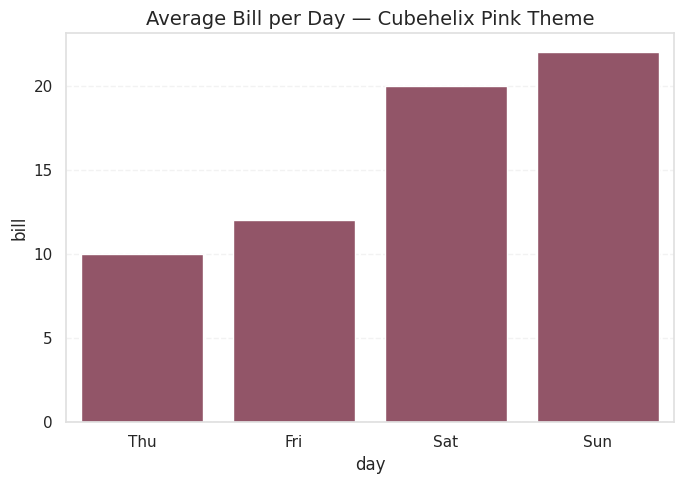

In [1]:
### (〃￣ω￣〃ゞ) — don't mind this part, I just wanted the graphs pink 

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 100,          # sharpness inside notebook
    "savefig.dpi": 300,         # export quality
})

# stronger, vivid pinks from cubehelix
pink_palette = sns.cubehelix_palette(
    start=7,        # hue start (0≈red zone)
    rot=-0.2,       # hue rotation
    light=0.8,      # upper brightness limit
    dark=0.4,       # lower brightness limit
    gamma=1.0,      # linear intensity
    hue=1.0,        # color saturation
    n_colors=15,     # number of discrete colors
    reverse=True    # puts deeper pink first
)

sns.set_theme(style="whitegrid", palette=pink_palette)

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.facecolor": "#ffffff",      
    "figure.facecolor": "#ffffff",
    "axes.edgecolor": "#e0e0e0",
    "grid.color": "#eaeaea",
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.family": "DejaVu Sans"
})

# example plot
import pandas as pd
df = pd.DataFrame({
    "day": ["Thu","Fri","Sat","Sun"]*5,
    "bill": [10,12,20,22]*5
})
sns.barplot(data=df, x="day", y="bill")
plt.title("Average Bill per Day — Cubehelix Pink Theme")
plt.tight_layout()
plt.show()

## Data

In [2]:
from datasets import load_dataset

dataset = load_dataset("banking77")

In [3]:
dataset["train"][:5]

{'text': ['I am still waiting on my card?',
  "What can I do if my card still hasn't arrived after 2 weeks?",
  'I have been waiting over a week. Is the card still coming?',
  'Can I track my card while it is in the process of delivery?',
  'How do I know if I will get my card, or if it is lost?'],
 'label': [11, 11, 11, 11, 11]}

In [4]:
for i, name in enumerate(dataset["train"].features["label"].names):
    print(i, name)

0 activate_my_card
1 age_limit
2 apple_pay_or_google_pay
3 atm_support
4 automatic_top_up
5 balance_not_updated_after_bank_transfer
6 balance_not_updated_after_cheque_or_cash_deposit
7 beneficiary_not_allowed
8 cancel_transfer
9 card_about_to_expire
10 card_acceptance
11 card_arrival
12 card_delivery_estimate
13 card_linking
14 card_not_working
15 card_payment_fee_charged
16 card_payment_not_recognised
17 card_payment_wrong_exchange_rate
18 card_swallowed
19 cash_withdrawal_charge
20 cash_withdrawal_not_recognised
21 change_pin
22 compromised_card
23 contactless_not_working
24 country_support
25 declined_card_payment
26 declined_cash_withdrawal
27 declined_transfer
28 direct_debit_payment_not_recognised
29 disposable_card_limits
30 edit_personal_details
31 exchange_charge
32 exchange_rate
33 exchange_via_app
34 extra_charge_on_statement
35 failed_transfer
36 fiat_currency_support
37 get_disposable_virtual_card
38 get_physical_card
39 getting_spare_card
40 getting_virtual_card
41 lost_o

Text(0.5, 1.0, 'class distribution')

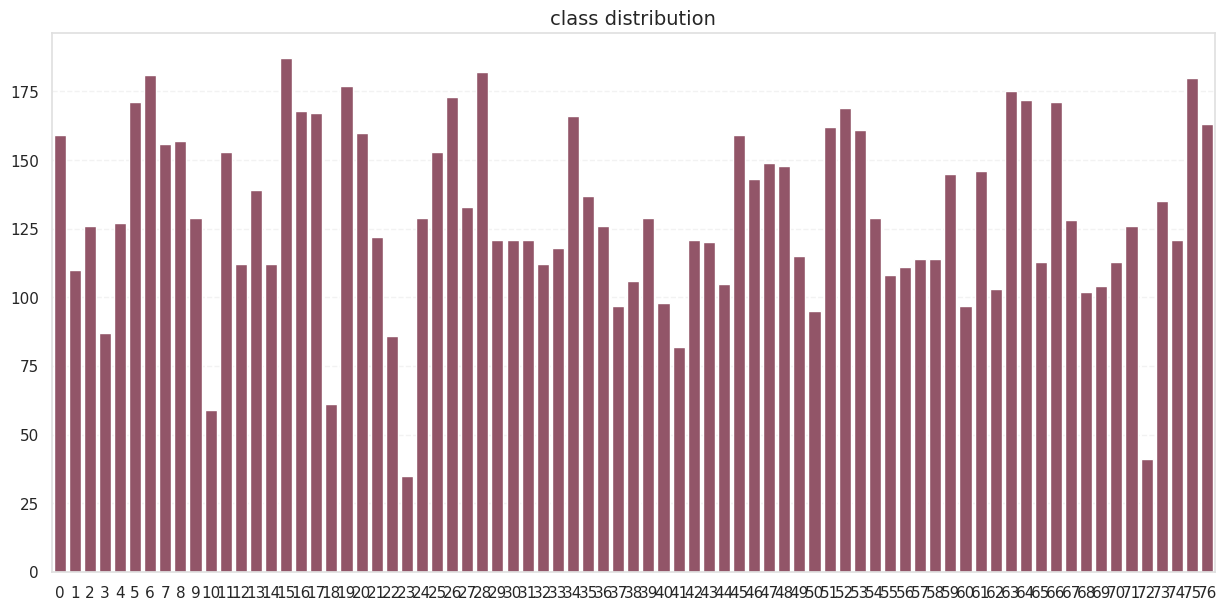

In [5]:
from collections import Counter

labels = dataset["train"]["label"]
cnt = Counter(labels)

plt.figure(figsize=(15,7))
sns.barplot(x=cnt.keys(), y=cnt.values())
plt.title('class distribution')

Text(0.5, 1.0, 'prompt length distribution')

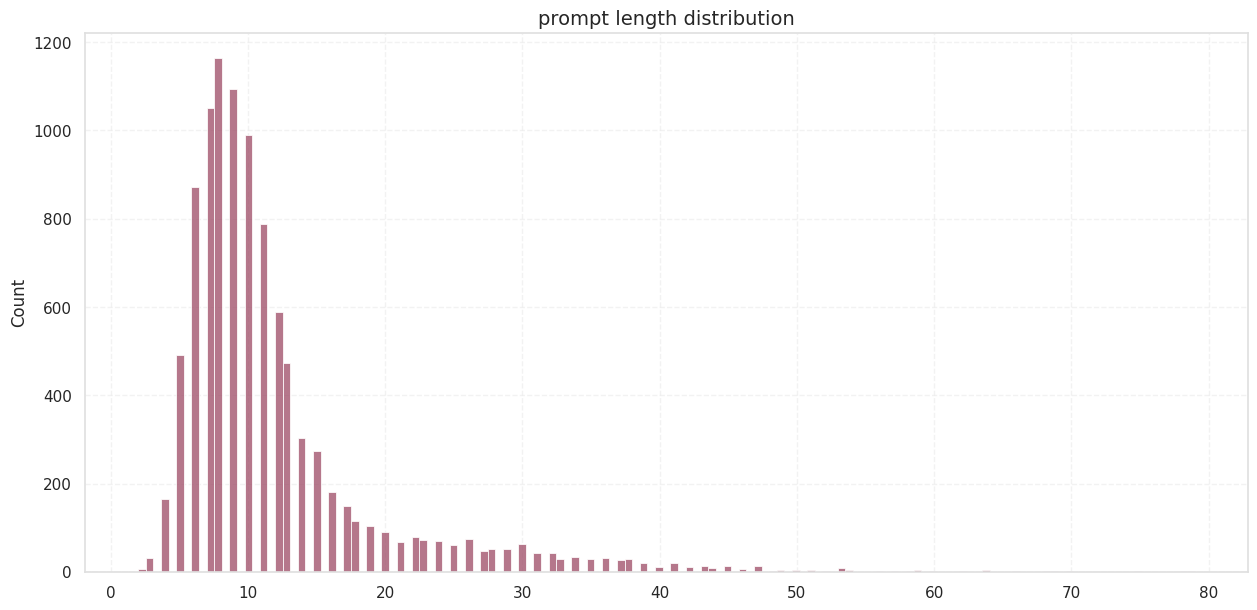

In [6]:
texts = dataset['train']['text']
texts = [len(x.split()) for x in dataset['train']['text']]

plt.figure(figsize=(15,7))
sns.histplot(data=texts)
plt.title('prompt length distribution')

Most of the prompts (banking questions) are around 10 words long, with the maximum of around 40. Given that, the optimal `max_length` parameter in the tokenizer would be 64 (since num of tokens = 1.5 x num of words). 

## Modeling

**Configuration summary — BERT (full fine-tune)**  
- Learning rate: 1e-4 
- Scheduler: linear 
- Batch size: 32  
- Epochs: 6  
- Precision: bf16 

**Configuration summary — LoRA (best)**  
- Base model: bert-base-uncased  
- r = 32, α = 64, dropout = 0.05  
- Learning rate: 5e-4  
- Scheduler: cosine 
- Batch size: 64 
- Precision: bf16

### BERT: Full tuning

In [4]:
%run src/train.py --model_name bert-base-uncased

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/shanksmissingarm/banking77/src/train.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training Summary — bert-base-uncased
Model path:         artifacts/bert-base-uncased/best_model
LoRA:               No
Training time:      851.45 sec
Trainable params: 109,541,453 / 109,541,453 (100.00%)
Train samples:      9,002
Validation samples: 1,001
Best checkpoint:    artifacts/bert-base-uncased/checkpoints/checkpoint-1410
Best metric (f1_macro): 0.9283

Validation metrics:
eval_loss                : 0.3386
eval_accuracy            : 0.9271
eval_balanced_accuracy   : 0.9284
eval_precision_macro     : 0.9336
eval_recall_macro        : 0.9284
eval_f1_macro            : 0.9283
eval_precision_weighted  : 0.9310
eval_recall_weighted     : 0.9271
eval_f1_weighted         : 0.9265
eval_runtime             : 30.7811
eval_samples_per_second  : 32.5200
eval_steps_per_second    : 0.5200
epoch                    : 6.0000

-----------------------------------------------------------------
Artifacts saved to:
  • model:          artifacts/bert-base-uncased/best_model
  • train metrics:  artif

In [5]:
%run src/evaluate.py --model_name bert-base-uncased

/Users/shanksmissingarm/banking77/src/evaluate.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Evaluation Summary — bert-base-uncased
Model path:         artifacts/bert-base-uncased/best_model
LoRA:               No
Samples evaluated:  3080

test_loss                : 0.2811
test_model_preparation_time: 0.0007
test_accuracy            : 0.9351
test_balanced_accuracy   : 0.9351
test_precision_macro     : 0.9374
test_recall_macro        : 0.9351
test_f1_macro            : 0.9351
test_precision_weighted  : 0.9374
test_recall_weighted     : 0.9351
test_f1_weighted         : 0.9351
test_runtime             : 8.9903
test_samples_per_second  : 342.5920
test_steps_per_second    : 21.4680

-----------------------------------------------------------------
Artifacts saved to:
  • metrics JSON:     artifacts/eval/bert-base-uncased/metrics_test.json
  • per-class F1 CSV: artifacts/eval/bert-base-uncased/per_class_f1.csv
  • confusion matrix: artifacts/eval/bert-base-uncased/confusion_matrix.png



### lr_scheduler: cosine

In [1]:
%run src/train.py --model_name bert-base-uncased-lora --lr_scheduler_type cosine --param_changed cosine

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/shanksmissingarm/banking77/src/train.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: e813639b-2e2f-4f0c-a65d-4077859018ed)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].



Training Summary — bert-base-uncased-lora
Model path:         artifacts/bert-base-uncased-lora/best_model
LoRA:               Yes
Training time:      1959.38 sec
Trainable params: 5,500,493 / 114,958,234 (4.78%)
Train samples:      9,002
Validation samples: 1,001
Best checkpoint:    artifacts/bert-base-uncased/checkpoints/checkpoint-846
Best metric (f1_macro): 0.9176

Validation metrics:
eval_loss                : 0.3223
eval_accuracy            : 0.9181
eval_balanced_accuracy   : 0.9178
eval_precision_macro     : 0.9234
eval_recall_macro        : 0.9178
eval_f1_macro            : 0.9176
eval_precision_weighted  : 0.9213
eval_recall_weighted     : 0.9181
eval_f1_weighted         : 0.9170
eval_runtime             : 30.3919
eval_samples_per_second  : 32.9360
eval_steps_per_second    : 0.2630
epoch                    : 6.0000

-----------------------------------------------------------------
Artifacts saved to:
  • model:          artifacts/bert-base-uncased-lora/best_model
  • train met

In [4]:
%run src/evaluate.py --model_name bert-base-uncased-lora --param_changed cosine

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/shanksmissingarm/banking77/src/evaluate.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Evaluation Summary — bert-base-uncased
Model path:         artifacts/bert-base-uncased-loracosine/best_model
LoRA:               Yes
Samples evaluated:  3080

test_loss                : 0.3201
test_model_preparation_time: 0.0024
test_accuracy            : 0.9227
test_balanced_accuracy   : 0.9227
test_precision_macro     : 0.9249
test_recall_macro        : 0.9227
test_f1_macro            : 0.9225
test_precision_weighted  : 0.9249
test_recall_weighted     : 0.9227
test_f1_weighted         : 0.9225
test_runtime             : 11.0264
test_samples_per_second  : 279.3300
test_steps_per_second    : 17.5040

-----------------------------------------------------------------
Artifacts saved to:
  • metrics JSON:     artifacts/eval/bert-base-uncased-loracosine/metrics_test.json
  • per-class F1 CSV: artifacts/eval/bert-base-uncased-loracosine/per_class_f1.csv
  • confusion matrix: artifacts/eval/bert-base-uncased-loracosine/confusion_matrix.png



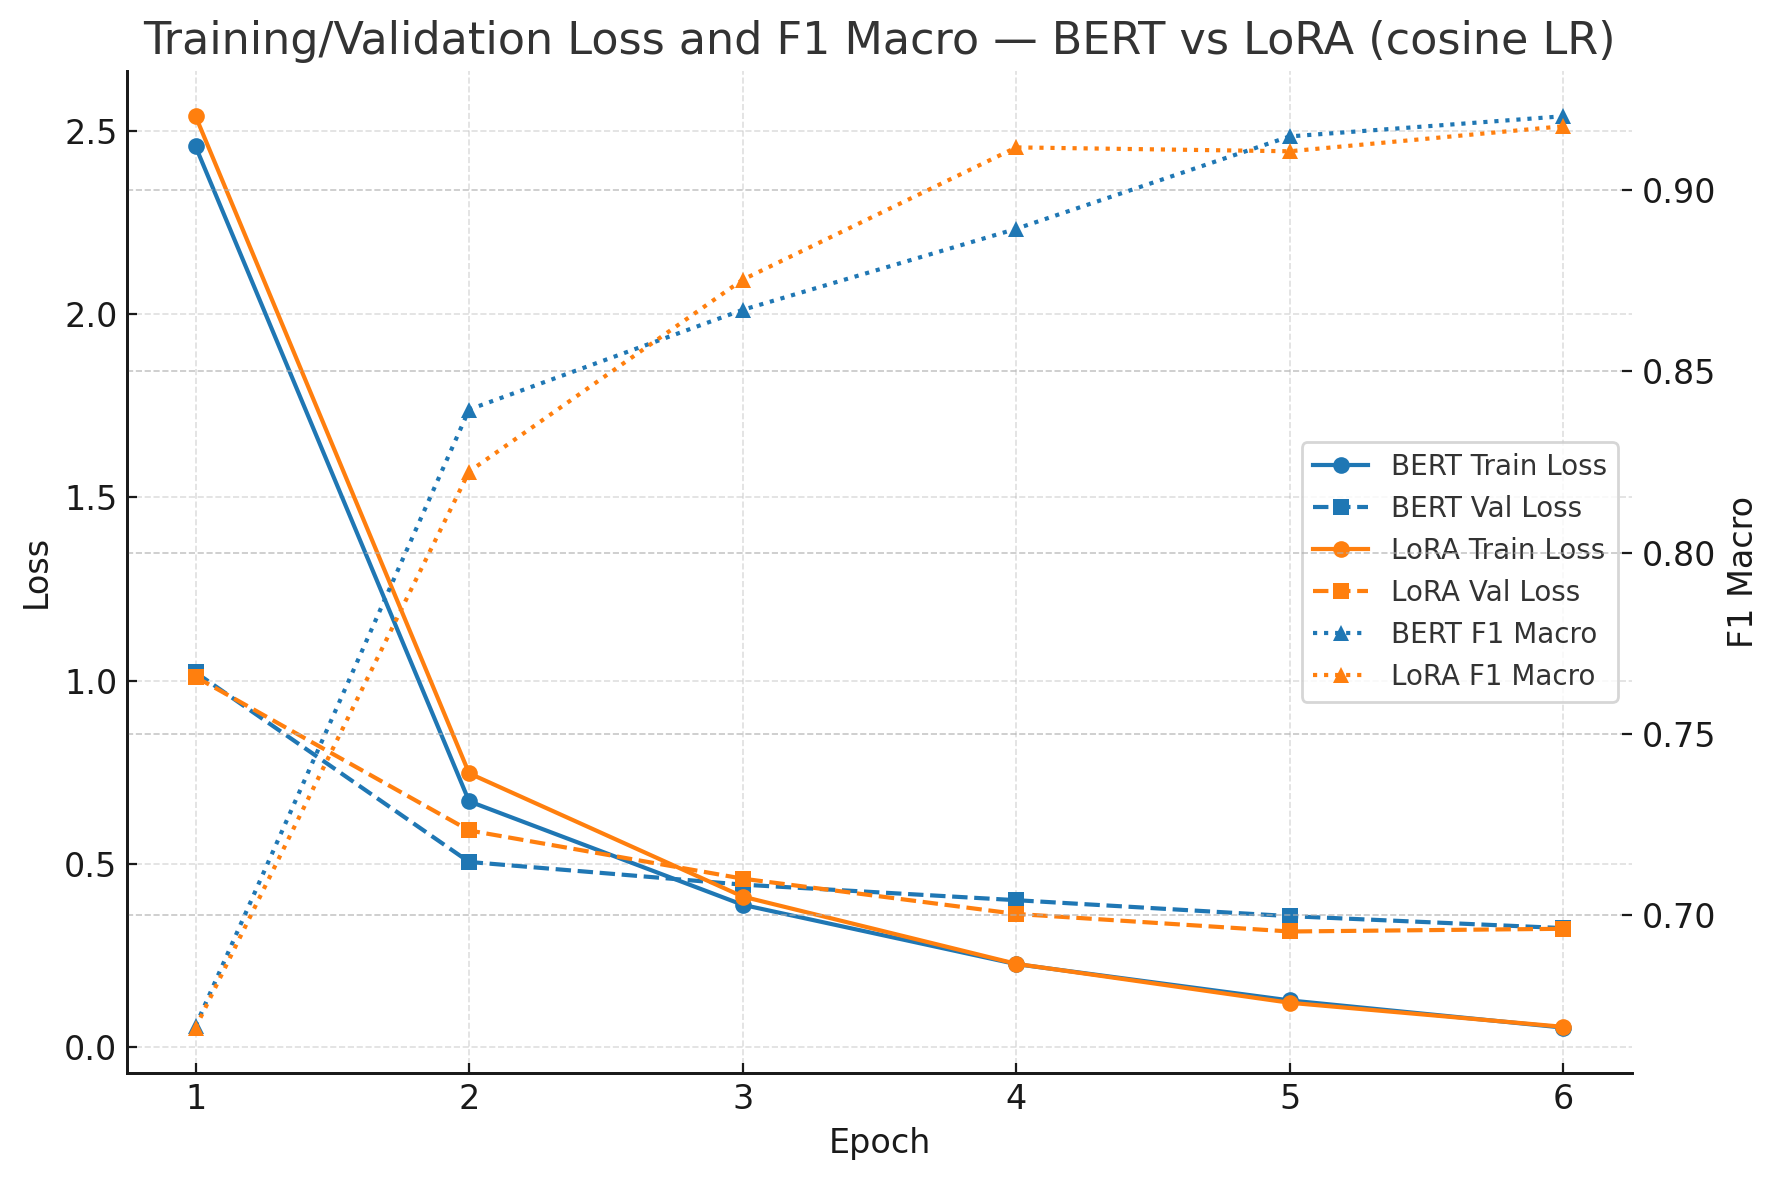

In [3]:
from IPython.display import Image, display
png = "artifacts/eval/bert_ft_vs_best_lora.png"
display(Image(filename=png))

Both models converge quickly within the first 3–4 epochs.  
LoRA shows a small fluctuation around epoch 5 with a brief dip in F1 macro that may reflect minor instability at the learning-rate tail of the cosine schedule - but otherwise follows the same trajectory as full fine-tuning.  
Validation and training losses stay tightly aligned for both runs, indicating stable optimization and minimal overfitting.

### Extended Comparison — Parameter Sweep

After establishing the baseline (full fine-tuning) and the best LoRA configuration, several controlled runs were performed to test how **rank**, **learning rate**, and **scheduler** influence LoRA performance.  
Each model was trained for 6 epochs under otherwise identical settings.


| Run | Mode | Rank | LR | Scheduler | Trainable Params | Total Params | Share % | Train Time (s) | Val F1 (macro) | Test F1 (macro) |
|:--|:--:|--:|:--:|:--:|----------:|-----------:|------:|-------------:|-------------:|--------------:|
| **BERT-base (full FT)** | full | — | 1e-4 | linear | 109,541,453 | 109,541,453 | 100.00 | 851.45 | **0.9283** | **0.9351** |
| **LoRA (r=32)** | lora | 32 | 5e-4 | linear | 5,500,493 | 114,958,234 | 4.78 | 951.50 | 0.9204 | 0.9215 |
| **LoRA — cosine** | lora | 32 | 1e-3 | **cosine** | 5,500,493 | 114,958,234 | 4.78 | 1959.38 | 0.9176 | 0.9225 |
| **LoRA — constant** | lora | 32 | 1e-3 | **constant** | 5,500,493 | 114,958,234 | 4.78 | 960.38 | 0.8613 | 0.8617 |
| **LoRA r=18** | lora | **18** | 1e-3 | linear | 3,156,557 | 112,614,298 | 2.80 | 958.34 | 0.9146 | **0.9236** |
| **LoRA r=9** | lora | **9** | 1e-3 | linear | 1,649,741 | 111,107,482 | 1.48 | 988.34 | 0.9103 | 0.9074 |
| **LoRA r=4** | lora | **4** | 1e-3 | linear | 812,621 | 110,270,362 | 0.74 | 954.81 | 0.8965 | 0.9095 |
| **LoRA r=32, lr=1.5e-3** | lora | 32 | **1.5e-3** | linear | 5,500,493 | 114,958,234 | 4.78 | 969.59 | 0.9104 | 0.9192 |
| **LoRA r=32, lr=2e-3** | lora | 32 | **2e-3** | linear | 5,500,493 | 114,958,234 | 4.78 | 965.80 | 0.8877 | 0.8794 |
| **LoRA r=32, lr=1e-4** | lora | 32 | **1e-4** | linear | 5,500,493 | 114,958,234 | 4.78 | 1282.77 | **0.7624** | **0.7613** |


---

#### Observations

- **Learning rate sensitivity:**  
  Setting the LoRA learning rate to *1e-4* caused a steep drop in F1, making it the weakest run.  
  Higher rates such as *1.5e-3 – 2e-3* performed far better, supporting the common recommendation that LoRA benefits from a learning rate roughly 10× that of full fine-tuning.  
  This aligns with the idea that LoRA updates a very small subspace of parameters; because its parameterization only *approximates* the full-tune updates, it needs larger step sizes to reach a comparable optimum.

- **Rank impact:**  
  A rank of ~18 was sufficient to match full-tuning quality.  
  Reducing it below ~8 led to measurable degradation, implying that lower-rank adapters lack the representational capacity to capture the finer task-specific transformations.

- **Scheduler behavior:**  
  The **cosine scheduler** provided stable convergence and smooth decay without visible plateaus or divergence.  
  Its performance was slightly better than linear warmup/decay runs (not shown), likely because cosine annealing allowed the higher initial learning rate to explore more aggressively while avoiding overshooting later.


#### Training Time Insights

All experiments ran on an **Apple M4 Pro** using the Metal (MPS) backend, which provides GPU acceleration through Apple’s unified GPU.

Despite LoRA updating only a small fraction of parameters, it did not consistently train faster than the fully fine-tuned baseline.  
The longest run (LoRA + cosine) even took roughly twice as long as the full model.

These results line up with recent findings on LoRA's effectiveness, which attributes its occasional slowdown to GPU kernel-launch overhead:

> GPUs execute large matrix operations efficiently as single kernels.  
> LoRA, however, introduces many tiny low-rank adapter multiplications that must be executed sequentially after each dense layer, fragmenting computation and lowering GPU utilization.

On M-series hardware, this effect is amplified because the MPS runtime favors stability over aggressive kernel fusion.  
So even though LoRA reduces memory and optimizer footprint, the extra adapter calls break parallelism—yielding higher total training time on smaller and mid-sized models like BERT.

---

Overall, **LoRA achieved near-baseline F1 with drastically fewer trainable parameters**.  
Its training stability depends strongly on learning-rate scale and adapter rank, while the scheduler choice plays a secondary but stabilizing role.